In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch

from IPython.display import clear_output
from tqdm import tqdm
from torchvision import models, datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
transforms_tensor = transforms.ToTensor()

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
path = ''#'/content/drive/MyDrive/Documents/whales'

train_folder = datasets.ImageFolder(os.path.join(path, 'whales_train'), transforms_tensor)
val_folder = datasets.ImageFolder(os.path.join(path, 'whales_val'), transforms_tensor)
test_folder = datasets.ImageFolder(os.path.join(path, 'whales_test'), transforms_tensor) 

batch_size = 50

dataloaders = {'train' : torch.utils.data.DataLoader(train_folder, batch_size=batch_size, shuffle=True),
               'val' : torch.utils.data.DataLoader(val_folder, batch_size=batch_size, shuffle=True),
               'test' :  torch.utils.data.DataLoader(test_folder, batch_size=batch_size, shuffle=False)}

sample_submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [6]:
model = models.resnet50()
clear_output()

# for param in model.parameters():
#   param.requires_grad = Falsez
model.fc = torch.nn.Linear(model.fc.in_features, len(train_folder.classes))
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), .001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(dataloaders['train']), epochs=100)

In [7]:
def train(model, optimizer, loss, epochs):
    model.to(device)
    metrics = [[], []]

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        for stage in ['train', 'val']:
            model.train() if stage == 'train' else model.eval()
            running_loss = 0.0
            running_acc = 0.0

            with torch.set_grad_enabled(stage == 'train'):
                for inputs, labels in tqdm(dataloaders[stage]):
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()
                    preds = model(inputs)
                    loss_value = loss(preds, labels)

                    if stage == 'train':
                        loss_value.backward()
                        optimizer.step()

                    # Validation: Ensure no tensor accumulation
                    if stage == 'val':
                        running_loss += loss_value.item()
                        running_acc += (preds.argmax(1) == labels).float().mean().item()

            # End of stage
            if stage == 'val':
                metrics[0].append(running_loss / len(dataloaders[stage]))
                metrics[1].append(running_acc / len(dataloaders[stage]))
                torch.cuda.empty_cache()  # Force cleanup

        clear_output()
    return metrics

In [18]:
metrics = train(model, optimizer, loss, 20)

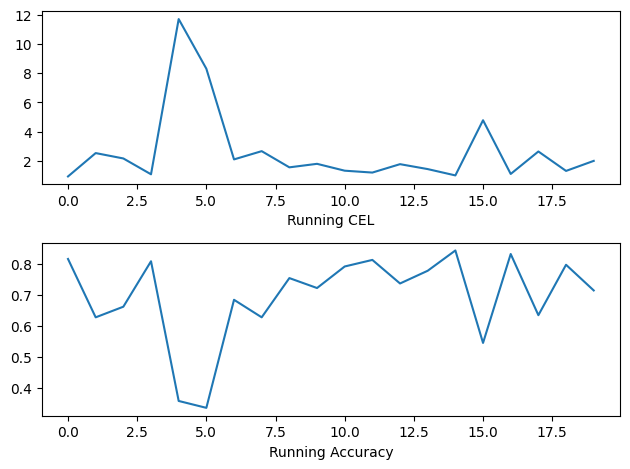

In [19]:
nrange = range(20)
l = len(metrics)
labels = ['Running CEL', 'Running Accuracy']

fig, axes = plt.subplots(l, 1)

for i in range(l):
    axes[i].plot(nrange, metrics[i])
    #axes[i].plot(nrange, metrics[1])
    axes[i].set_xlabel(labels[i])
plt.tight_layout()
plt.show()

In [20]:
model = model.eval()

In [21]:
submission_preds = []
for inputs, labels in tqdm(dataloaders['test']):
                inputs = inputs.to(device)
            
                preds = model.forward(inputs).sort(dim=1)[1][:, -5:].tolist()
                submission_preds.extend(preds)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:30<00:00, 10.39it/s]


In [22]:
submission = sample_submission
submission['Id'] = submission_preds

In [23]:
classes = train_folder.classes
submission = submission.set_index('Image')
submission['Id'] = submission['Id'].map(lambda x: ' '.join([classes[i] for i in x[::-1]]))

In [24]:
submission

,Id
Image,
00029b3a.jpg,new_whale w_a8ec52f w_104cc93 w_37a7f78 w_3eaef21
0003c693.jpg,w_80245ee w_e964ae8 new_whale w_0b775c1 w_f4844e7
000bc353.jpg,w_ca5f17f w_520d618 new_whale w_4f82020 w_ecbf9fa
0010a672.jpg,new_whale w_367b996 w_44a6b62 w_861cc1c w_987a36f
00119c3f.jpg,new_whale w_7eb2c7c w_0ead9d7 w_41fa033 w_0d48a7d
...,...
fff31d26.jpg,new_whale w_1287fbc w_9db9ef5 w_cae7677 w_dcb1f2a
fff3d049.jpg,w_b39c722 new_whale w_511c464 w_61ffd2c w_7b3f9d1
fffa5100.jpg,new_whale w_be0fefb w_1dff010 w_4659acf w_89317b0


In [26]:
submission.to_csv('sub.csv')